# Удалить!

In [296]:
# OLLAMA_HOST https://3c04-34-19-60-242.ngrok-free.app/
# TAVILY_API_KEY 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
# МБ не тот
# LANGSMITH_API_KEY a7df7cb4-3f10-492c-bf0c-2b93f3939d6c 

### Local RAG agent with LLaMA3

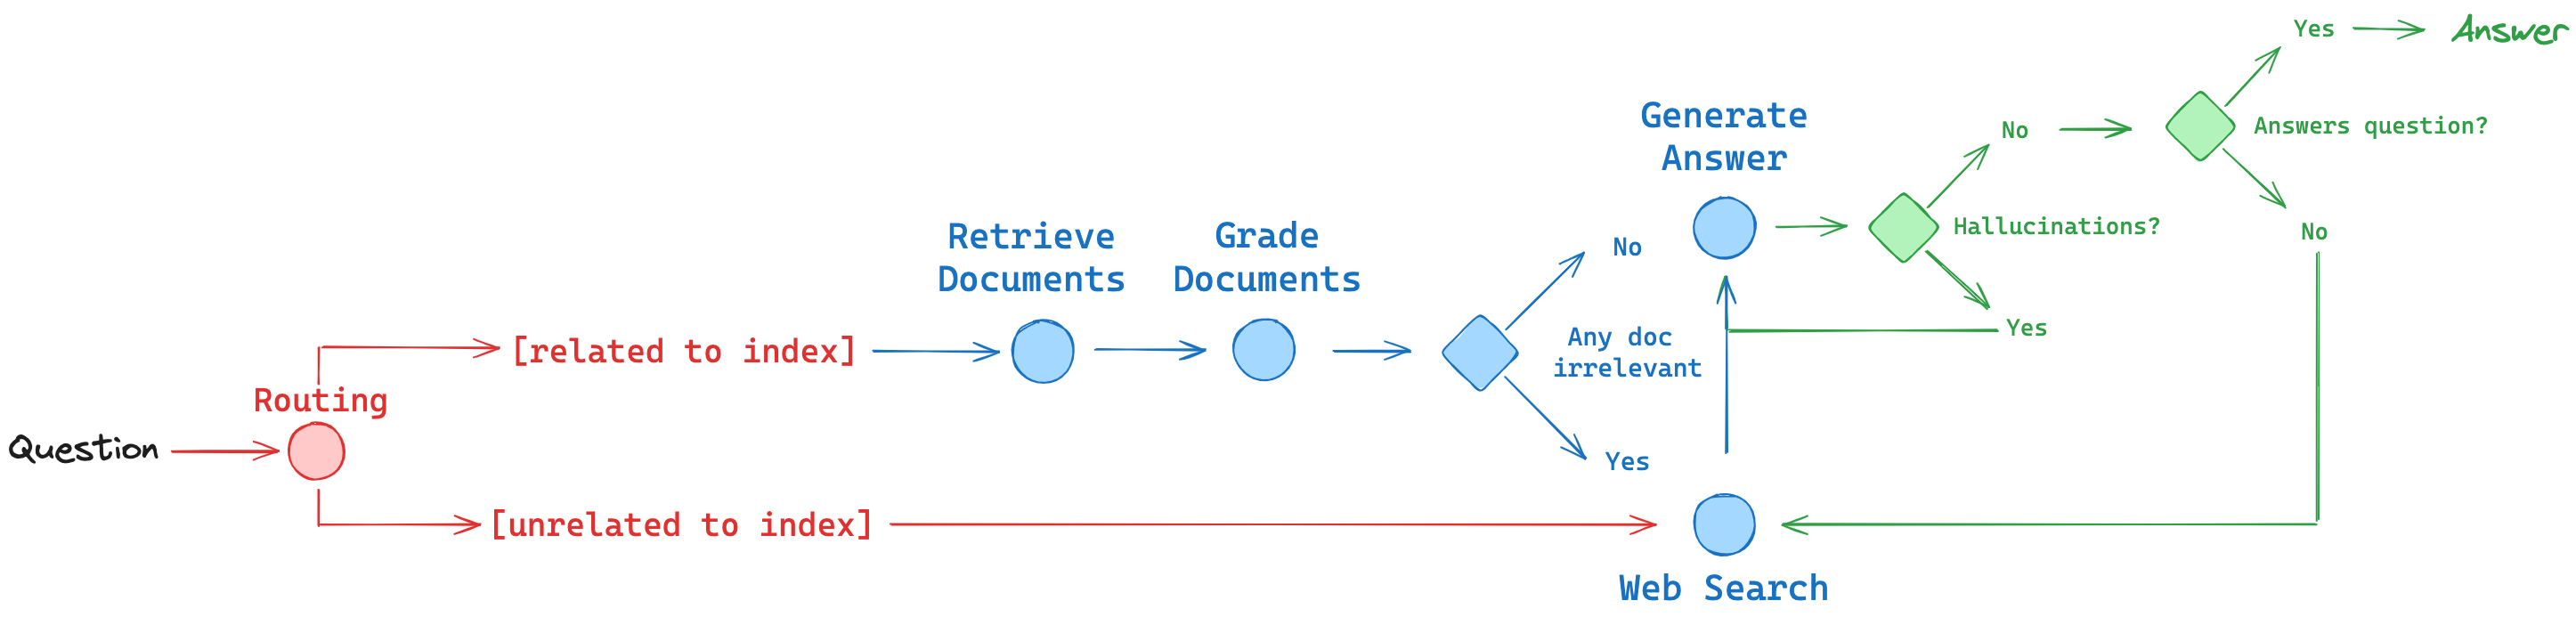

**LLM**

In [233]:
### LLM
from langchain_ollama import ChatOllama
import os
import getpass

In [6]:
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

In [362]:
os.environ["OLLAMA_HOST"] = "https://c36d-34-169-120-64.ngrok-free.app/"

In [363]:
!ollama pull "llama3.2:3b-instruct-fp16"

pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest 
pulling e2f46f5b501c...   0% ▕                ▏    0 B/6.4 GB                  pulling manifest 
pulling e2f46f5b501c...   0% ▕                ▏    0 B/6.4 GB                  pulling manifest 
pulling e2f46f5b501c...   0% ▕                ▏  58 KB/6.4 GB                  pulling manifest 
pulling e2f46f5b501c...   0% ▕               ▏ 10.0 MB/6.4 GB                  pulling manifest 
pulling e2f46f5b501c...   1% ▕                ▏  53 MB/6.4 GB                  pulling manifest 
pulling e2f46f5b501c...   2% ▕                ▏  97 MB/6.4 GB                  pulling manifest 
pulling e2f46f5b501c

In [369]:
local_llm = "llama3.2:3b-instruct-fp16"
llm = ChatOllama(model=local_llm, temperature=0, num_ctx=4096)
llm_json_mode = ChatOllama(model=local_llm, temperature=0, format="json", num_ctx=4096)

**Search**

In [8]:
_set_env("TAVILY_API_KEY")
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [236]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "local-llama32-rag"

**Vectorstore**

In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_nomic.embeddings import NomicEmbeddings

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [237]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/"
]

In [238]:
# load docs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

In [240]:
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200)

In [241]:
doc_splits = text_splitter.split_documents(docs_list)

In [ ]:
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=NomicEmbeddings(model='nomic-embed-text-v1.5', inference_mode='remote'))

Downloading: 100%|██████████| 274M/274M [00:11<00:00, 24.3MiB/s] 
Verifying: 100%|██████████| 274M/274M [00:01<00:00, 266MiB/s] 


In [313]:
retriever = vectorstore.as_retriever(search_kwargs={'k': 3})

In [314]:
retriever.invoke('Ai agent')

[Document(metadata={'id': '4bf648df-9b11-498e-be3b-0b5820e1a1bd', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en'}, page_content="LLM Powered Autonomous Agents | Lil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLil'Log\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nPosts\n\n\n\n\nArchive\n\n\n\n\nSearch\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n\n\n\nemojisearch.app\n\n\n\n\n\

**Components**

In [244]:
### Router
import json
from langchain_core.messages import HumanMessage, SystemMessage

In [245]:
# Prompt
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.

The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.

Use the vectorstore for questions on these topics. For all else, and especially for current events, use web-search.

Return JSON with single key, datasource, that is 'websearch' or 'vectorstore' depending on the question.
"""

In [246]:
# Test router
test_web_search = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)] + \
    [HumanMessage(content="Who is favored to win the NFC Championship game in the 2024 season?")])

In [247]:
test_web_search_2 = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="What are the models released today for llama3.2?")])

In [248]:
test_vector_store = llm_json_mode.invoke(
    [SystemMessage(content=router_instructions)]
    + [HumanMessage(content="What are the types of agent memory?")]
)

In [249]:
print(
    json.loads(test_web_search.content),
    json.loads(test_web_search_2.content),
    json.loads(test_vector_store.content),
)

{'datasource': 'websearch'} {'datasource': 'websearch'} {'datasource': 'vectorstore'}


In [268]:
### Retrieval Grader

# Doc grader instructions
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant."""

# Grader prompt
doc_grader_prompt = """Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}. 

This carefully and objectively assess whether the document contains at least some information that is relevant to the question.

Return JSON with single key, binary_score, that is 'yes' or 'no' score to indicate whether the document contains at least some information that is relevant to the question."""

# Test
question = "What is Chain of thought prompting?"
docs = retriever.invoke(question)
doc_txt = docs[1].page_content
doc_grader_prompt_formatted = doc_grader_prompt.format(
    document=doc_txt, question=question
)
result = llm_json_mode.invoke(
    [SystemMessage(content=doc_grader_instructions)]
    + [HumanMessage(content=doc_grader_prompt_formatted)]
)
json.loads(result.content)

{'binary_score': 'yes'}

In [269]:
### Generate

# Prompt
rag_prompt = """You are an assistant for question-answering tasks. 
Here is the context to use to answer the question:
{context} 
Think carefully about the above context. 
Now, review the user question:
{question}
Provide an answer to this questions using only the above context. 
Use three sentences maximum and keep the answer concise.
Answer:"""

In [271]:
# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [272]:
docs = retriever.invoke(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)

In [300]:
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])

In [301]:
print(generation.content)

Chain of Thought (CoT) prompting is a technique used in natural language processing (NLP) to generate human-like text by iteratively refining a prompt through multiple rounds of search, evaluation, and optimization. CoT prompts are designed to mimic the way humans think and reason, with each iteration building upon the previous one to produce a more accurate and coherent response. This process involves generating multiple pseudo-chains of thought, pruning them based on accuracy, and selecting the best candidates through iterative refinement.


In [338]:
### Hallucination Grader

# Hallucination grader instructions
hallucination_grader_instructions = """
You are a teacher grading a quiz. 
You will be given FACTS and a STUDENT ANSWER. 
Here is the grade criteria to follow:
(1) Ensure the STUDENT ANSWER is grounded in the FACTS. 
(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.
Score:
A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 
A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.
Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 
Avoid simply stating the correct answer at the outset."""

In [339]:
hallucination_grader_prompt = """FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}. 
Return JSON with two two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER is grounded in the FACTS. And a key, explanation, that contains an explanation of the score."""

In [341]:
# Test using documents and generation from above
hallucination_grader_prompt_formatted  = hallucination_grader_prompt.format(documents=docs_txt, generation=generation)

In [342]:
result = llm_json_mode.invoke(
    [SystemMessage(content=hallucination_grader_instructions)] + \
    [HumanMessage(content=hallucination_grader_prompt_formatted)])

In [343]:
json.loads(result.content)

{'binary_score': 'no',
 'explanation': 'The student answer does not meet all of the criteria. While it mentions Chain-of-Thought (CoT) prompting, it does not accurately describe its purpose or process. CoT prompting is a technique used in natural language processing to generate human-like text by iteratively refining a prompt through multiple rounds of search, evaluation, and optimization. However, the student answer does not provide any information about how this process works or how it is used to improve the accuracy and coherence of responses. Additionally, the student answer contains some incorrect information, such as stating that CoT prompts are designed to mimic the way humans think and reason in a linear fashion, when in fact they involve generating multiple pseudo-chains of thought and pruning them based on accuracy.'}

**Check the number of tokens**

В сумме должно быть меньше, чем 4096

In [352]:
llm_json_mode.get_num_tokens_from_messages([SystemMessage(content=hallucination_grader_instructions)] + \
    [HumanMessage(content=hallucination_grader_prompt_formatted)])

3477

In [353]:
llm_json_mode.get_num_tokens(json.loads(result.content)['explanation'])

152

In [370]:
### Answer Grader

# Answer grader instructions
answer_grader_instructions = """You are a teacher grading a quiz. 
You will be given a QUESTION and a STUDENT ANSWER. 
Here is the grade criteria to follow:
(1) The STUDENT ANSWER helps to answer the QUESTION
Score:
A score of yes means that the student's answer meets all of the criteria. This is the highest (best) score. 
The student can receive a score of yes if the answer contains extra information that is not explicitly asked for in the question.
A score of no means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.
Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 
Avoid simply stating the correct answer at the outset."""

In [371]:
# Grader prompt
answer_grader_prompt = """QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}. 
Return JSON with two keys, binary_score is 'yes' or 'no' score to indicate whether the STUDENT ANSWER meets the criteria. And a key, explanation, that contains an explanation of the score."""

In [372]:
# Test
question = "What are the vision models released today as part of Llama 3.2?"
answer = "The Llama 3.2 models released today include two vision models: Llama 3.2 11B Vision Instruct and Llama 3.2 90B Vision Instruct, which are available on Azure AI Model Catalog via managed compute. These models are part of Meta's first foray into multimodal AI and rival closed models like Anthropic's Claude 3 Haiku and OpenAI's GPT-4o mini in visual reasoning. They replace the older text-only Llama 3.1 models."

In [373]:
# Test using question and generation from above
answer_grader_promt_formatted = answer_grader_prompt.format(question=question, generation=answer)

In [374]:
result = llm_json_mode.invoke(
    [SystemMessage(content=answer_grader_instructions)] + \
    [HumanMessage(content=answer_grader_promt_formatted)])

In [375]:
json.loads(result.content)

{'binary_score': 'yes',
 'explanation': "The student's answer helps to answer the question by providing specific details about the vision models released as part of Llama 3.2. The answer mentions two vision models (Llama 3.2 11B Vision Instruct and Llama 3.2 90B Vision Instruct) and their availability on Azure AI Model Catalog via managed compute. Additionally, the student provides context about Meta's first foray into multimodal AI and compares these models to other visual reasoning models like Claude 3 Haiku and GPT-4o mini. This extra information is not explicitly asked for in the question, but it demonstrates a thorough understanding of the topic. The answer also correctly states that these models replace the older text-only Llama 3.1 models, which meets all the criteria specified in the question."}

**Web search Tool**

In [279]:
from langchain_community.tools.tavily_search import TavilySearchResults

In [308]:
web_search_tool = TavilySearchResults(max_results=3)

In [309]:
search = web_search_tool.invoke(question)

In [310]:
search[0]['url']

'https://www.unite.ai/what-is-chain-of-thought-cot-prompting-examples-benefits/'